In [200]:
import datascience as ds
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from datetime import datetime
seaborn.set_context(rc={'lines.markeredgewidth': 1.0})
%matplotlib inline
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from collections import Counter
import pandas as pd
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 7.5
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

The data is named SF_taxi_data.csv, and contains San Francisco Taxi data from 9/1/2012 to 9/17/2012. The dataset consists of 50,000 taxi trips taken in the Bay Area during that time period. For each trip you are given the departure time, arrival time, passenger fare, departure lat/lon coordinates, arrival lat/lon coordinates, departure taz (Traffic Analysis Zone), arrival taz, and the distance between origin and destination in miles.

Data might have outliers and errors. To make sure that you have removed all the outliers, do the following: 

• Get trips where the number of passengers is only 1, and remove fares less than $3.5, since base fare
= $3.5, these are likely to be errors. Do the rest of analysis on this filtered data.

In [201]:
taxi_data=ds.Table.read_table("SF_taxi_data.csv")
taxi_data=taxi_data.where("num", 1)
taxi_data=taxi_data.where(list(map(lambda x: x>=3.5, taxi_data["fare ($)"])))
#taxi_data=taxi_data.where(list(map(lambda x: x>0, taxi_data["dist (miles)"])))
taxi_data.sort("dist (miles)")
#taxi_data
#check to see relationship between speed of drivers and number of rides per day or rides per hour

id,departure time,arrival time,fare ($),num,dep lon,dep lat,arr lon,arr lat,deptaz,arrtaz,dist (miles)
232,9/1/12 0:04,9/1/12 0:06,4.05,1,-122.459,37.7837,-122.456,37.786,70,70,0
444,9/1/12 0:23,9/1/12 0:25,6.6,1,-122.425,37.771,-122.423,37.775,81,81,0
693,9/1/12 1:14,9/1/12 1:16,4.05,1,-122.424,37.7767,-122.423,37.7752,79,79,0
894,9/1/12 13:55,9/1/12 14:01,7.35,1,-122.413,37.8078,-122.405,37.8062,41,41,0
1024,9/1/12 13:45,9/1/12 13:47,5.15,1,-122.415,37.7796,-122.419,37.7828,9,9,0
1070,9/1/12 0:34,9/1/12 0:51,16.15,1,-122.42,37.7691,-122.42,37.7652,106,106,0
1388,9/1/12 18:33,9/1/12 20:03,137.45,1,-122.387,37.617,-122.386,37.618,239,239,0
1597,9/1/12 14:15,9/1/12 14:19,5.7,1,-122.405,37.8063,-122.414,37.8073,41,41,0
1687,9/1/12 2:11,9/1/12 2:13,5.15,1,-122.422,37.7905,-122.416,37.7929,32,32,0
1775,9/1/12 11:33,9/1/12 11:36,6.25,1,-122.455,37.7756,-122.445,37.776,69,69,0


SFMTA fare calculation table states that the fare for a trip of x miles will be at least 3.5 + 0.55 × (5x − 1). Explore how this compares to the actual relationship between fares and distance that you can find using regression methods that you have learned in class.


1. First, find the regression line of the table.
2. Plot both the actual regression line and the regression line given to compare.

In [202]:
#Slope of line = 3.5 + 2.75x-.55 -> 2.95 +2.75X.
#y = fare & x = number of miles
theta1=2.75 #m
theta2=2.95 #b
theta_theory = np.array([2.75,2.95])
theta_theory

array([ 2.75,  2.95])

In [203]:
relevant_data = taxi_data.select("fare ($)", "dist (miles)")
#dist = taxi_data.select("dist (miles)") #x
#fare = taxi_data.select("fare ($)") #y
dist = relevant_data["dist (miles)"]
fare = relevant_data["fare ($)"]

In [204]:
x_dist = np.vstack([dist, np.ones(len(dist))]).T
theta_from_data = np.linalg.solve(x_dist.T.dot(x_dist), x_dist.T.dot(fare))
print("Coefficients obtained by Linear Algebra: ",theta_from_data)

Coefficients obtained by Linear Algebra:  [ 3.3335993   5.08626184]


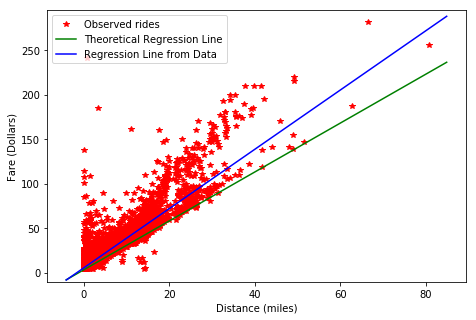

In [214]:
plt.plot(dist, fare, 'r*')
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot(xlim, [theta_theory[0]*xlim[0]+theta_theory[1], theta_theory[0]*xlim[1]+theta_theory[1]], 'g-')
plt.plot(xlim, [theta_from_data[0]*xlim[0]+theta_from_data[1], theta_from_data[0]*xlim[1]+theta_from_data[1]], 'b-')

plt.ylim(ylim)
plt.legend(["Observed rides","Theoretical Regression Line", "Regression Line from Data"], loc="upper left")
plt.xlabel("Distance (miles)")
plt.ylabel("Fare (Dollars)")

## Analysis 2

Turns out the TAZ that contains SFO (San Francisco International Airport) is the TAZ that generates the most trips. find the most popular “deptaz” and save the taz id as sfo_taz. Then split the dataset into two groups of trips that originated or ended at SFO, and the rest of the trips. What can you say about these two groups of data? How different they are? (your answers need to be quantitative, based on some measures or metrics)

In [215]:
most_common_dep = Counter(taxi_data["deptaz"])
print(most_common_dep.most_common(1))

[(239, 3477)]


In [216]:
sfo_taz= 239

In [217]:
def time_to_delta(t):
    return datetime.timedelta(hours=t.hour, minutes=t.minute, seconds=t.second)

taxi_data['Dep. Datetime'] = taxi_data.select('departure time').apply(lambda x : datetime.strptime(x[0], "%m/%d/%y %H:%M"))
taxi_data['Arr. Datetime'] = taxi_data.select('arrival time').apply(lambda x : datetime.strptime(x[0], "%m/%d/%y %H:%M"))
taxi_data["Extra Fare"] = taxi_data['fare ($)'] - (3.5 + 0.55 * 5 * taxi_data['dist (miles)'] - 0.55)
taxi_data["Trip Duration"] = taxi_data["Arr. Datetime"] - taxi_data["Dep. Datetime"]
taxi_data["Trip Duration (seconds)"] = taxi_data.select('Trip Duration').apply(lambda x : x[0].total_seconds())
taxi_data["Time of day"] = taxi_data.select("Dep. Datetime").apply(lambda x : x[0].time())
taxi_data["Hour of day"] = taxi_data.select("Time of day").apply(lambda x : x[0].hour)
taxi_data["Day of the week"] = taxi_data.select("Dep. Datetime").apply(lambda x : x[0].date().weekday())
taxi_data['speed (mph)'] = taxi_data['dist (miles)']/(taxi_data['Trip Duration (seconds)']/3600)
#taxi_data

In [218]:
sfo_dep_data=taxi_data.where(list(map(lambda x: x==sfo_taz, taxi_data["deptaz"])))
sfo_arr_data=taxi_data.where(list(map(lambda x: x==sfo_taz, taxi_data["arrtaz"])))
all_sfo_data = sfo_arr_data.append(sfo_dep_data)
#sfo_dep_data
#sfo_arr_data
#all_sfo_data

In [219]:
no_sfo_data=taxi_data.where(list(map(lambda x: x!=sfo_taz, taxi_data["deptaz"])))
no_sfo_data=taxi_data.where(list(map(lambda x: x!=sfo_taz, taxi_data["arrtaz"])))
#no_sfo_data

In [220]:
##### Where are most people coming from to get to SFO #####
most_common_arv_from_SFO = Counter(all_sfo_data["arrtaz"])
print("most people come from Traffic Analysis Zone #", most_common_arv_from_SFO.most_common(2)[1][0])
##### Most common destination for people leaving SFO #####
most_common_dep_from_SFO = Counter(all_sfo_data["deptaz"])
print("most common destination from SFO #",most_common_dep_from_SFO.most_common(2)[1][0])

most people come from Traffic Analysis Zone # 7
most common destination from SFO # 12


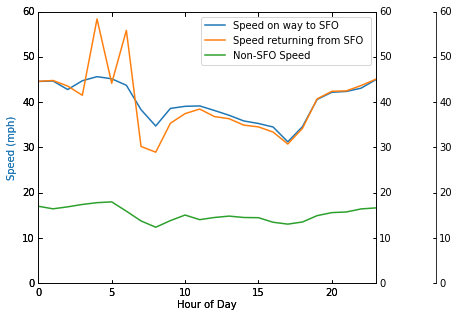

In [221]:
###Additional Analysis: Do taxi drivers drive quicker to the Airport? ####
avg0 = sfo_arr_data.where(list(map(lambda x: x== 0, sfo_arr_data["Hour of day"])))["speed (mph)"].mean()
avg1 = sfo_arr_data.where(list(map(lambda x: x== 1, sfo_arr_data["Hour of day"])))["speed (mph)"].mean()
avg2 = sfo_arr_data.where(list(map(lambda x: x== 2, sfo_arr_data["Hour of day"])))["speed (mph)"].mean()
avg3 = sfo_arr_data.where(list(map(lambda x: x== 3, sfo_arr_data["Hour of day"])))["speed (mph)"].mean()
avg4 = sfo_arr_data.where(list(map(lambda x: x== 4, sfo_arr_data["Hour of day"])))["speed (mph)"].mean()
avg5 = sfo_arr_data.where(list(map(lambda x: x== 5, sfo_arr_data["Hour of day"])))["speed (mph)"].mean()
avg6 = sfo_arr_data.where(list(map(lambda x: x== 6, sfo_arr_data["Hour of day"])))["speed (mph)"].mean()
avg7 = sfo_arr_data.where(list(map(lambda x: x== 7, sfo_arr_data["Hour of day"])))["speed (mph)"].mean()
avg8 = sfo_arr_data.where(list(map(lambda x: x== 8, sfo_arr_data["Hour of day"])))["speed (mph)"].mean()
avg9 = sfo_arr_data.where(list(map(lambda x: x== 9, sfo_arr_data["Hour of day"])))["speed (mph)"].mean()
avg10 = sfo_arr_data.where(list(map(lambda x: x== 10, sfo_arr_data["Hour of day"])))["speed (mph)"].mean()
avg11 = sfo_arr_data.where(list(map(lambda x: x== 11, sfo_arr_data["Hour of day"])))["speed (mph)"].mean()
avg12 = sfo_arr_data.where(list(map(lambda x: x== 12, sfo_arr_data["Hour of day"])))["speed (mph)"].mean()
avg13 = sfo_arr_data.where(list(map(lambda x: x== 13, sfo_arr_data["Hour of day"])))["speed (mph)"].mean()
avg14 = sfo_arr_data.where(list(map(lambda x: x== 14, sfo_arr_data["Hour of day"])))["speed (mph)"].mean()
avg15 = sfo_arr_data.where(list(map(lambda x: x== 15, sfo_arr_data["Hour of day"])))["speed (mph)"].mean()
avg16 = sfo_arr_data.where(list(map(lambda x: x== 16, sfo_arr_data["Hour of day"])))["speed (mph)"].mean()
avg17 = sfo_arr_data.where(list(map(lambda x: x== 17, sfo_arr_data["Hour of day"])))["speed (mph)"].mean()
avg18 = sfo_arr_data.where(list(map(lambda x: x== 18, sfo_arr_data["Hour of day"])))["speed (mph)"].mean()
avg19 = sfo_arr_data.where(list(map(lambda x: x== 19, sfo_arr_data["Hour of day"])))["speed (mph)"].mean()
avg20 = sfo_arr_data.where(list(map(lambda x: x== 20, sfo_arr_data["Hour of day"])))["speed (mph)"].mean()
avg21 = sfo_arr_data.where(list(map(lambda x: x== 21, sfo_arr_data["Hour of day"])))["speed (mph)"].mean()
avg22 = sfo_arr_data.where(list(map(lambda x: x== 22, sfo_arr_data["Hour of day"])))["speed (mph)"].mean()
avg23 = sfo_arr_data.where(list(map(lambda x: x== 23, sfo_arr_data["Hour of day"])))["speed (mph)"].mean()

arr_speed_avg =[avg0,avg1,avg2,avg3,avg4,avg5,avg6,avg7,avg8,avg9,avg10,avg11,avg12,avg13,avg14,
           avg15,avg16,avg17,avg18,avg19,avg20,avg21,avg22,avg23]

avg0 = sfo_dep_data.where(list(map(lambda x: x== 0, sfo_dep_data["Hour of day"])))["speed (mph)"].mean()
avg1 = sfo_dep_data.where(list(map(lambda x: x== 1, sfo_dep_data["Hour of day"])))["speed (mph)"].mean()
avg2 = sfo_dep_data.where(list(map(lambda x: x== 2, sfo_dep_data["Hour of day"])))["speed (mph)"].mean()
avg3 = sfo_dep_data.where(list(map(lambda x: x== 3, sfo_dep_data["Hour of day"])))["speed (mph)"].mean()
avg4 = sfo_dep_data.where(list(map(lambda x: x== 4, sfo_dep_data["Hour of day"])))["speed (mph)"].mean()
avg5 = sfo_dep_data.where(list(map(lambda x: x== 5, sfo_dep_data["Hour of day"])))["speed (mph)"].mean()
avg6 = sfo_dep_data.where(list(map(lambda x: x== 6, sfo_dep_data["Hour of day"])))["speed (mph)"].mean()
avg7 = sfo_dep_data.where(list(map(lambda x: x== 7, sfo_dep_data["Hour of day"])))["speed (mph)"].mean()
avg8 = sfo_dep_data.where(list(map(lambda x: x== 8, sfo_dep_data["Hour of day"])))["speed (mph)"].mean()
avg9 = sfo_dep_data.where(list(map(lambda x: x== 9, sfo_dep_data["Hour of day"])))["speed (mph)"].mean()
avg10 = sfo_dep_data.where(list(map(lambda x: x== 10, sfo_dep_data["Hour of day"])))["speed (mph)"].mean()
avg11 = sfo_dep_data.where(list(map(lambda x: x== 11, sfo_dep_data["Hour of day"])))["speed (mph)"].mean()
avg12 = sfo_dep_data.where(list(map(lambda x: x== 12, sfo_dep_data["Hour of day"])))["speed (mph)"].mean()
avg13 = sfo_dep_data.where(list(map(lambda x: x== 13, sfo_dep_data["Hour of day"])))["speed (mph)"].mean()
avg14 = sfo_dep_data.where(list(map(lambda x: x== 14, sfo_dep_data["Hour of day"])))["speed (mph)"].mean()
avg15 = sfo_dep_data.where(list(map(lambda x: x== 15, sfo_dep_data["Hour of day"])))["speed (mph)"].mean()
avg16 = sfo_dep_data.where(list(map(lambda x: x== 16, sfo_dep_data["Hour of day"])))["speed (mph)"].mean()
avg17 = sfo_dep_data.where(list(map(lambda x: x== 17, sfo_dep_data["Hour of day"])))["speed (mph)"].mean()
avg18 = sfo_dep_data.where(list(map(lambda x: x== 18, sfo_dep_data["Hour of day"])))["speed (mph)"].mean()
avg19 = sfo_dep_data.where(list(map(lambda x: x== 19, sfo_dep_data["Hour of day"])))["speed (mph)"].mean()
avg20 = sfo_dep_data.where(list(map(lambda x: x== 20, sfo_dep_data["Hour of day"])))["speed (mph)"].mean()
avg21 = sfo_dep_data.where(list(map(lambda x: x== 21, sfo_dep_data["Hour of day"])))["speed (mph)"].mean()
avg22 = sfo_dep_data.where(list(map(lambda x: x== 22, sfo_dep_data["Hour of day"])))["speed (mph)"].mean()
avg23 = sfo_dep_data.where(list(map(lambda x: x== 23, sfo_dep_data["Hour of day"])))["speed (mph)"].mean()

dep_speed_avg =[avg0,avg1,avg2,avg3,avg4,avg5,avg6,avg7,avg8,avg9,avg10,avg11,avg12,avg13,avg14,
           avg15,avg16,avg17,avg18,avg19,avg20,avg21,avg22,avg23]

avg0 = no_sfo_data.where(list(map(lambda x: x== 0, no_sfo_data["Hour of day"])))["speed (mph)"].mean()
avg1 = no_sfo_data.where(list(map(lambda x: x== 1, no_sfo_data["Hour of day"])))["speed (mph)"].mean()
avg2 = no_sfo_data.where(list(map(lambda x: x== 2, no_sfo_data["Hour of day"])))["speed (mph)"].mean()
avg3 = no_sfo_data.where(list(map(lambda x: x== 3, no_sfo_data["Hour of day"])))["speed (mph)"].mean()
avg4 = no_sfo_data.where(list(map(lambda x: x== 4, no_sfo_data["Hour of day"])))["speed (mph)"].mean()
avg5 = no_sfo_data.where(list(map(lambda x: x== 5, no_sfo_data["Hour of day"])))["speed (mph)"].mean()
avg6 = no_sfo_data.where(list(map(lambda x: x== 6, no_sfo_data["Hour of day"])))["speed (mph)"].mean()
avg7 = no_sfo_data.where(list(map(lambda x: x== 7, no_sfo_data["Hour of day"])))["speed (mph)"].mean()
avg8 = no_sfo_data.where(list(map(lambda x: x== 8, no_sfo_data["Hour of day"])))["speed (mph)"].mean()
avg9 = no_sfo_data.where(list(map(lambda x: x== 9, no_sfo_data["Hour of day"])))["speed (mph)"].mean()
avg10 = no_sfo_data.where(list(map(lambda x: x== 10, no_sfo_data["Hour of day"])))["speed (mph)"].mean()
avg11 = no_sfo_data.where(list(map(lambda x: x== 11, no_sfo_data["Hour of day"])))["speed (mph)"].mean()
avg12 = no_sfo_data.where(list(map(lambda x: x== 12, no_sfo_data["Hour of day"])))["speed (mph)"].mean()
avg13 = no_sfo_data.where(list(map(lambda x: x== 13, no_sfo_data["Hour of day"])))["speed (mph)"].mean()
avg14 = no_sfo_data.where(list(map(lambda x: x== 14, no_sfo_data["Hour of day"])))["speed (mph)"].mean()
avg15 = no_sfo_data.where(list(map(lambda x: x== 15, no_sfo_data["Hour of day"])))["speed (mph)"].mean()
avg16 = no_sfo_data.where(list(map(lambda x: x== 16, no_sfo_data["Hour of day"])))["speed (mph)"].mean()
avg17 = no_sfo_data.where(list(map(lambda x: x== 17, no_sfo_data["Hour of day"])))["speed (mph)"].mean()
avg18 = no_sfo_data.where(list(map(lambda x: x== 18, no_sfo_data["Hour of day"])))["speed (mph)"].mean()
avg19 = no_sfo_data.where(list(map(lambda x: x== 19, no_sfo_data["Hour of day"])))["speed (mph)"].mean()
avg20 = no_sfo_data.where(list(map(lambda x: x== 20, no_sfo_data["Hour of day"])))["speed (mph)"].mean()
avg21 = no_sfo_data.where(list(map(lambda x: x== 21, no_sfo_data["Hour of day"])))["speed (mph)"].mean()
avg22 = no_sfo_data.where(list(map(lambda x: x== 22, no_sfo_data["Hour of day"])))["speed (mph)"].mean()
avg23 = no_sfo_data.where(list(map(lambda x: x== 23, no_sfo_data["Hour of day"])))["speed (mph)"].mean()

no_sfo_data =[avg0,avg1,avg2,avg3,avg4,avg5,avg6,avg7,avg8,avg9,avg10,avg11,avg12,avg13,avg14,
           avg15,avg16,avg17,avg18,avg19,avg20,avg21,avg22,avg23]


host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

offset = 60
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right",
                                    axes=par2,
                                    offset=(offset, 0))

par2.axis["right"].toggle(all=True)


host.set_xlim(0, 23)
host.set_ylim(0, 60)
par1.set_ylim(0, 60)
par2.set_ylim(0, 60)

host.set_xlabel("Hour of Day")
host.set_ylabel("Speed (mph)")


p1, = host.plot([0,1, 2,3,4,5,6,7,8,9,10, 11, 12,13,14,15,16,17,18,19,20,21,22,23], arr_speed_avg, label="Speed on way to SFO")
p2, = par1.plot([0,1, 2,3,4,5,6,7,8,9,10, 11, 12,13,14,15,16,17,18,19,20,21,22,23], dep_speed_avg, label="Speed returning from SFO ")
p3, = par2.plot([0,1, 2,3,4,5,6,7,8,9,10, 11, 12,13,14,15,16,17,18,19,20,21,22,23], no_sfo_data, label="Non-SFO Speed")



host.legend()

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())


plt.draw()
plt.show()



In [179]:
np.mean(arr_speed_avg), np.mean(dep_speed_avg),np.mean(no_sfo_data)

(40.036198814787717, 39.932157951259605, 15.263246972780825)

## General Relationships

Coefficients obtained by Linear Algebra for Departing from SFO:  [ 3.61463981  0.06317118]
Coefficients obtained by Linear Algebra for Arriving to SFO:  [ 3.74507837 -0.13431351]
Coefficients obtained by Linear Algebra with No SFO relation:  [ 3.47382434  4.85196606]


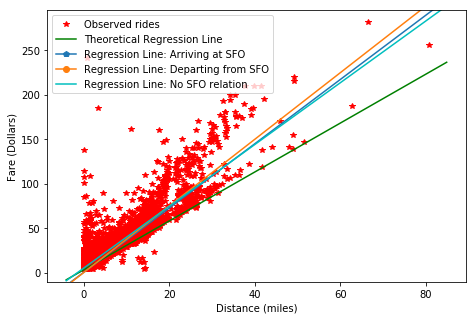

In [197]:
dist_arr = sfo_arr_data["dist (miles)"]
fare_arr = sfo_arr_data["fare ($)"]
dist_dep = sfo_dep_data["dist (miles)"]
fare_dep = sfo_dep_data["fare ($)"]
dist_no_sfo = no_sfo_data["dist (miles)"]
fare_no_sfo = no_sfo_data["fare ($)"]
########
x_dist_arr = np.vstack([dist_arr, np.ones(len(dist_arr))]).T
theta_from_data_arr = np.linalg.solve(x_dist_arr.T.dot(x_dist_arr), x_dist_arr.T.dot(fare_arr))
print("Coefficients obtained by Linear Algebra for Departing from SFO: ",theta_from_data_arr)
x_dist_dep = np.vstack([dist_dep, np.ones(len(dist_dep))]).T
theta_from_data_dep = np.linalg.solve(x_dist_dep.T.dot(x_dist_dep), x_dist_dep.T.dot(fare_dep))
print("Coefficients obtained by Linear Algebra for Arriving to SFO: ",theta_from_data_dep)
x_dist_no_sfo = np.vstack([dist_no_sfo, np.ones(len(dist_no_sfo))]).T
theta_from_data_no_sfo = np.linalg.solve(x_dist_no_sfo.T.dot(x_dist_no_sfo), x_dist_no_sfo.T.dot(fare_no_sfo))
print("Coefficients obtained by Linear Algebra with No SFO relation: ",theta_from_data_no_sfo)
########
plt.plot(dist, fare, 'r*')
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot(xlim, [theta_theory[0]*xlim[0]+theta_theory[1], theta_theory[0]*xlim[1]+theta_theory[1]], 'g-')
plt.plot(xlim, [theta_from_data_arr[0]*xlim[0]+theta_from_data_arr[1], theta_from_data_arr[0]*xlim[1]+theta_from_data_arr[1]], 'p-')
plt.plot(xlim, [theta_from_data_dep[0]*xlim[0]+theta_from_data_dep[1], theta_from_data_dep[0]*xlim[1]+theta_from_data_dep[1]], 'o-')
plt.plot(xlim, [theta_from_data_no_sfo[0]*xlim[0]+theta_from_data_no_sfo[1], theta_from_data_no_sfo[0]*xlim[1]+theta_from_data_no_sfo[1]], 'c-')


plt.ylim(ylim)
plt.legend(["Observed rides","Theoretical Regression Line", "Regression Line: Arriving at SFO","Regression Line: Departing from SFO","Regression Line: No SFO relation"], loc="upper left")
plt.xlabel("Distance (miles)")
plt.ylabel("Fare (Dollars)")

## Relationship between speed of drivers and number of rides per day or rides per hour 

In [180]:
taxi_data["Time of day"] = taxi_data.select("Dep. Datetime").apply(lambda x : x[0].time())
taxi_data["Hour of day"] = taxi_data.select("Time of day").apply(lambda x : x[0].hour)
taxi_data["Day of the week"] = taxi_data.select("Dep. Datetime").apply(lambda x : x[0].date().weekday())
taxi_data['speed (mph)'] = taxi_data['dist (miles)']/(taxi_data['Trip Duration (seconds)']/3600)
#a=taxi_data['Arr. Datetime'][4]-taxi_data['Dep. Datetime'][4]
#taxi_data["Time of day (seconds)"] = taxi_data.select("Time of day").apply(lambda x: time_to_delta(x[0]).total_seconds())
#taxi_data


In [181]:
#taxi_data['time (seconds)'] = taxi_data.select('time (seconds)').apply(lambda x : x[0].total_seconds()/60)
taxi_data['speed (mph)'] = taxi_data['dist (miles)']/(taxi_data['Trip Duration (seconds)']/3600)
a=taxi_data['Arr. Datetime'][4]-taxi_data['Dep. Datetime'][4]
#a.total_seconds()
#taxi_data["Time of day"] = taxi_data.select("Dep. Datetime").apply(lambda x : x[0].time())
#taxi_data["Time of day (seconds)"] = taxi_data.select("Time of day").apply(lambda x: time_to_delta(x[0]).total_seconds())
#taxi_data["Hour of day"] = taxi_data.select("Time of day").apply(lambda x : x[0].hour)
#taxi_data["Day of the week"] = taxi_data.select("Dep. Datetime").apply(lambda x : x[0].date().weekday())
#taxi_data

In [182]:
taxi_data_weekdays = taxi_data.where(list(map(lambda x: x < 5, taxi_data["Day of the week"])))
taxi_data_weekends = taxi_data.where(list(map(lambda x: x >= 5, taxi_data["Day of the week"])))

In [183]:
mon_avg = taxi_data.where(list(map(lambda x: x== 0, taxi_data["Day of the week"])))["speed (mph)"].mean()
tue_avg = taxi_data.where(list(map(lambda x: x== 1, taxi_data["Day of the week"])))["speed (mph)"].mean()
wed_avg = taxi_data.where(list(map(lambda x: x== 2, taxi_data["Day of the week"])))["speed (mph)"].mean()
thu_avg = taxi_data.where(list(map(lambda x: x== 3, taxi_data["Day of the week"])))["speed (mph)"].mean()
fri_avg = taxi_data.where(list(map(lambda x: x== 4, taxi_data["Day of the week"])))["speed (mph)"].mean()
sat_avg = taxi_data.where(list(map(lambda x: x== 5, taxi_data["Day of the week"])))["speed (mph)"].mean()
sun_avg = taxi_data.where(list(map(lambda x: x== 6, taxi_data["Day of the week"])))["speed (mph)"].mean()
week_avg=[mon_avg,tue_avg,wed_avg,thu_avg,fri_avg,sat_avg,sun_avg]
#day_avg

week_ride0 = taxi_data.where(list(map(lambda x: x== 0, taxi_data["Day of the week"]))).shape[0][0][0]
week_ride1 = taxi_data.where(list(map(lambda x: x== 1, taxi_data["Day of the week"]))).shape[0][0][0]
week_ride2 = taxi_data.where(list(map(lambda x: x== 2, taxi_data["Day of the week"]))).shape[0][0][0]
week_ride3 = taxi_data.where(list(map(lambda x: x== 3, taxi_data["Day of the week"]))).shape[0][0][0]
week_ride4 = taxi_data.where(list(map(lambda x: x== 4, taxi_data["Day of the week"]))).shape[0][0][0]
week_ride5 = taxi_data.where(list(map(lambda x: x== 5, taxi_data["Day of the week"]))).shape[0][0][0]
week_ride6 = taxi_data.where(list(map(lambda x: x== 6, taxi_data["Day of the week"]))).shape[0][0][0]

week_ride = [week_ride0,week_ride1,week_ride2,week_ride3,week_ride4,week_ride5,week_ride6]
#week_ride

mon_dist = taxi_data.where(list(map(lambda x: x== 0, taxi_data["Day of the week"])))["dist (miles)"].mean()
tue_dist = taxi_data.where(list(map(lambda x: x== 1, taxi_data["Day of the week"])))["dist (miles)"].mean()
wed_dist = taxi_data.where(list(map(lambda x: x== 2, taxi_data["Day of the week"])))["dist (miles)"].mean()
thu_dist = taxi_data.where(list(map(lambda x: x== 3, taxi_data["Day of the week"])))["dist (miles)"].mean()
fri_dist = taxi_data.where(list(map(lambda x: x== 4, taxi_data["Day of the week"])))["dist (miles)"].mean()
sat_dist = taxi_data.where(list(map(lambda x: x== 5, taxi_data["Day of the week"])))["dist (miles)"].mean()
sun_dist = taxi_data.where(list(map(lambda x: x== 6, taxi_data["Day of the week"])))["dist (miles)"].mean()
week_dist=[mon_dist,tue_dist,wed_dist,thu_dist,fri_dist,sat_dist,sun_dist]
#week_dist

/srv/app/venv/lib/python3.6/site-packages/datascience/tables.py:192: FutureWarning: Implicit column method lookup is deprecated.
  warnings.warn("Implicit column method lookup is deprecated.", FutureWarning)


In [184]:
avg0 = taxi_data.where(list(map(lambda x: x== 0, taxi_data["Hour of day"])))["speed (mph)"].mean()
avg1 = taxi_data.where(list(map(lambda x: x== 1, taxi_data["Hour of day"])))["speed (mph)"].mean()
avg2 = taxi_data.where(list(map(lambda x: x== 2, taxi_data["Hour of day"])))["speed (mph)"].mean()
avg3 = taxi_data.where(list(map(lambda x: x== 3, taxi_data["Hour of day"])))["speed (mph)"].mean()
avg4 = taxi_data.where(list(map(lambda x: x== 4, taxi_data["Hour of day"])))["speed (mph)"].mean()
avg5 = taxi_data.where(list(map(lambda x: x== 5, taxi_data["Hour of day"])))["speed (mph)"].mean()
avg6 = taxi_data.where(list(map(lambda x: x== 6, taxi_data["Hour of day"])))["speed (mph)"].mean()
avg7 = taxi_data.where(list(map(lambda x: x== 7, taxi_data["Hour of day"])))["speed (mph)"].mean()
avg8 = taxi_data.where(list(map(lambda x: x== 8, taxi_data["Hour of day"])))["speed (mph)"].mean()
avg9 = taxi_data.where(list(map(lambda x: x== 9, taxi_data["Hour of day"])))["speed (mph)"].mean()
avg10 = taxi_data.where(list(map(lambda x: x== 10, taxi_data["Hour of day"])))["speed (mph)"].mean()
avg11 = taxi_data.where(list(map(lambda x: x== 11, taxi_data["Hour of day"])))["speed (mph)"].mean()
avg12 = taxi_data.where(list(map(lambda x: x== 12, taxi_data["Hour of day"])))["speed (mph)"].mean()
avg13 = taxi_data.where(list(map(lambda x: x== 13, taxi_data["Hour of day"])))["speed (mph)"].mean()
avg14 = taxi_data.where(list(map(lambda x: x== 14, taxi_data["Hour of day"])))["speed (mph)"].mean()
avg15 = taxi_data.where(list(map(lambda x: x== 15, taxi_data["Hour of day"])))["speed (mph)"].mean()
avg16 = taxi_data.where(list(map(lambda x: x== 16, taxi_data["Hour of day"])))["speed (mph)"].mean()
avg17 = taxi_data.where(list(map(lambda x: x== 17, taxi_data["Hour of day"])))["speed (mph)"].mean()
avg18 = taxi_data.where(list(map(lambda x: x== 18, taxi_data["Hour of day"])))["speed (mph)"].mean()
avg19 = taxi_data.where(list(map(lambda x: x== 19, taxi_data["Hour of day"])))["speed (mph)"].mean()
avg20 = taxi_data.where(list(map(lambda x: x== 20, taxi_data["Hour of day"])))["speed (mph)"].mean()
avg21 = taxi_data.where(list(map(lambda x: x== 21, taxi_data["Hour of day"])))["speed (mph)"].mean()
avg22 = taxi_data.where(list(map(lambda x: x== 22, taxi_data["Hour of day"])))["speed (mph)"].mean()
avg23 = taxi_data.where(list(map(lambda x: x== 23, taxi_data["Hour of day"])))["speed (mph)"].mean()


hour_avg =[avg0,avg1,avg2,avg3,avg4,avg5,avg6,avg7,avg8,avg9,avg10,avg11,avg12,avg13,avg14,
           avg15,avg16,avg17,avg18,avg19,avg20,avg21,avg22,avg23]

dist0 = taxi_data.where(list(map(lambda x: x== 0, taxi_data["Hour of day"])))["dist (miles)"].mean()
dist1 = taxi_data.where(list(map(lambda x: x== 1, taxi_data["Hour of day"])))["dist (miles)"].mean()
dist2 = taxi_data.where(list(map(lambda x: x== 2, taxi_data["Hour of day"])))["dist (miles)"].mean()
dist3 = taxi_data.where(list(map(lambda x: x== 3, taxi_data["Hour of day"])))["dist (miles)"].mean()
dist4 = taxi_data.where(list(map(lambda x: x== 4, taxi_data["Hour of day"])))["dist (miles)"].mean()
dist5 = taxi_data.where(list(map(lambda x: x== 5, taxi_data["Hour of day"])))["dist (miles)"].mean()
dist6 = taxi_data.where(list(map(lambda x: x== 6, taxi_data["Hour of day"])))["dist (miles)"].mean()
dist7 = taxi_data.where(list(map(lambda x: x== 7, taxi_data["Hour of day"])))["dist (miles)"].mean()
dist8 = taxi_data.where(list(map(lambda x: x== 8, taxi_data["Hour of day"])))["dist (miles)"].mean()
dist9 = taxi_data.where(list(map(lambda x: x== 9, taxi_data["Hour of day"])))["dist (miles)"].mean()
dist10 = taxi_data.where(list(map(lambda x: x== 10, taxi_data["Hour of day"])))["dist (miles)"].mean()
dist11 = taxi_data.where(list(map(lambda x: x== 11, taxi_data["Hour of day"])))["dist (miles)"].mean()
dist12 = taxi_data.where(list(map(lambda x: x== 12, taxi_data["Hour of day"])))["dist (miles)"].mean()
dist13 = taxi_data.where(list(map(lambda x: x== 13, taxi_data["Hour of day"])))["dist (miles)"].mean()
dist14 = taxi_data.where(list(map(lambda x: x== 14, taxi_data["Hour of day"])))["dist (miles)"].mean()
dist15 = taxi_data.where(list(map(lambda x: x== 15, taxi_data["Hour of day"])))["dist (miles)"].mean()
dist16 = taxi_data.where(list(map(lambda x: x== 16, taxi_data["Hour of day"])))["dist (miles)"].mean()
dist17 = taxi_data.where(list(map(lambda x: x== 17, taxi_data["Hour of day"])))["dist (miles)"].mean()
dist18 = taxi_data.where(list(map(lambda x: x== 18, taxi_data["Hour of day"])))["dist (miles)"].mean()
dist19 = taxi_data.where(list(map(lambda x: x== 19, taxi_data["Hour of day"])))["dist (miles)"].mean()
dist20 = taxi_data.where(list(map(lambda x: x== 20, taxi_data["Hour of day"])))["dist (miles)"].mean()
dist21 = taxi_data.where(list(map(lambda x: x== 21, taxi_data["Hour of day"])))["dist (miles)"].mean()
dist22 = taxi_data.where(list(map(lambda x: x== 22, taxi_data["Hour of day"])))["dist (miles)"].mean()
dist23 = taxi_data.where(list(map(lambda x: x== 23, taxi_data["Hour of day"])))["dist (miles)"].mean()

hour_dist = [dist0, 
            dist1, dist2,  dist3,             dist4, dist5,             dist6, 
            dist7,             dist8,             dist9,             dist10, dist11,             dist12, 
            dist13,             dist14,            dist15,             dist16, 
            dist17,             dist18, 
            dist19, dist20,  dist21,             dist22, 
            dist23,]
#hour_dist

In [185]:
num_ride0 = taxi_data.where(list(map(lambda x: x== 0, taxi_data["Hour of day"]))).shape[0][0][0]
num_ride1 = taxi_data.where(list(map(lambda x: x== 1, taxi_data["Hour of day"]))).shape[0][0][0]
num_ride2 = taxi_data.where(list(map(lambda x: x== 2, taxi_data["Hour of day"]))).shape[0][0][0]
num_ride3 = taxi_data.where(list(map(lambda x: x== 3, taxi_data["Hour of day"]))).shape[0][0][0]
num_ride4 = taxi_data.where(list(map(lambda x: x== 4, taxi_data["Hour of day"]))).shape[0][0][0]
num_ride5 = taxi_data.where(list(map(lambda x: x== 5, taxi_data["Hour of day"]))).shape[0][0][0]
num_ride6 = taxi_data.where(list(map(lambda x: x== 6, taxi_data["Hour of day"]))).shape[0][0][0]
num_ride7 = taxi_data.where(list(map(lambda x: x== 7, taxi_data["Hour of day"]))).shape[0][0][0]
num_ride8 = taxi_data.where(list(map(lambda x: x== 8, taxi_data["Hour of day"]))).shape[0][0][0]
num_ride9 = taxi_data.where(list(map(lambda x: x== 9, taxi_data["Hour of day"]))).shape[0][0][0]
num_ride10 = taxi_data.where(list(map(lambda x: x== 10, taxi_data["Hour of day"]))).shape[0][0][0]
num_ride11 = taxi_data.where(list(map(lambda x: x== 11, taxi_data["Hour of day"]))).shape[0][0][0]
num_ride12 = taxi_data.where(list(map(lambda x: x== 12, taxi_data["Hour of day"]))).shape[0][0][0]
num_ride13 = taxi_data.where(list(map(lambda x: x== 13, taxi_data["Hour of day"]))).shape[0][0][0]
num_ride14 = taxi_data.where(list(map(lambda x: x== 14, taxi_data["Hour of day"]))).shape[0][0][0]
num_ride15 = taxi_data.where(list(map(lambda x: x== 15, taxi_data["Hour of day"]))).shape[0][0][0]
num_ride16 = taxi_data.where(list(map(lambda x: x== 16, taxi_data["Hour of day"]))).shape[0][0][0]
num_ride17 = taxi_data.where(list(map(lambda x: x== 17, taxi_data["Hour of day"]))).shape[0][0][0]
num_ride18 = taxi_data.where(list(map(lambda x: x== 18, taxi_data["Hour of day"]))).shape[0][0][0]
num_ride19 = taxi_data.where(list(map(lambda x: x== 19, taxi_data["Hour of day"]))).shape[0][0][0]
num_ride20 = taxi_data.where(list(map(lambda x: x== 20, taxi_data["Hour of day"]))).shape[0][0][0]
num_ride21 = taxi_data.where(list(map(lambda x: x== 21, taxi_data["Hour of day"]))).shape[0][0][0]
num_ride22 = taxi_data.where(list(map(lambda x: x== 22, taxi_data["Hour of day"]))).shape[0][0][0]
num_ride23 = taxi_data.where(list(map(lambda x: x== 23, taxi_data["Hour of day"]))).shape[0][0][0]

num_rides = [num_ride0,num_ride1, num_ride2,
            num_ride3,           num_ride4,            num_ride5,            num_ride6,            num_ride7,            num_ride8,            num_ride9,            num_ride10,
            num_ride11,            num_ride12,            num_ride13,            num_ride14,            num_ride15,            num_ride16,
            num_ride17,            num_ride18,            num_ride19,            num_ride20,
            num_ride21,            num_ride22,            num_ride23,]
#num_rides

/srv/app/venv/lib/python3.6/site-packages/datascience/tables.py:192: FutureWarning: Implicit column method lookup is deprecated.
  warnings.warn("Implicit column method lookup is deprecated.", FutureWarning)


In [186]:
#plt.plot(hour_avg, "*")

In [187]:
#plt.plot(num_rides, "*")

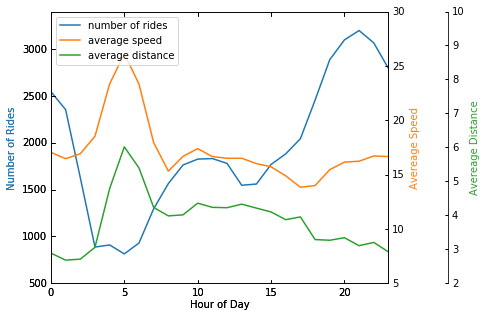

In [188]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

offset = 60
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right",
                                    axes=par2,
                                    offset=(offset, 0))

par2.axis["right"].toggle(all=True)


host.set_xlim(0, 23)
host.set_ylim(500, 3400)
par1.set_ylim(5, 30)
par2.set_ylim(2, 10)

host.set_xlabel("Hour of Day")
host.set_ylabel("Number of Rides")
par1.set_ylabel("Avereage Speed")
par2.set_ylabel("Avereage Distance")

p1, = host.plot([0,1, 2,3,4,5,6,7,8,9,10, 11, 12,13,14,15,16,17,18,19,20,21,22,23], num_rides, label="number of rides")
p2, = par1.plot([0,1, 2,3,4,5,6,7,8,9,10, 11, 12,13,14,15,16,17,18,19,20,21,22,23], hour_avg, label="average speed")
p3, = par2.plot([0,1, 2,3,4,5,6,7,8,9,10, 11, 12,13,14,15,16,17,18,19,20,21,22,23], hour_dist, label="average distance")



host.legend()

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right"].label.set_color(p3.get_color())


plt.draw()
plt.show()

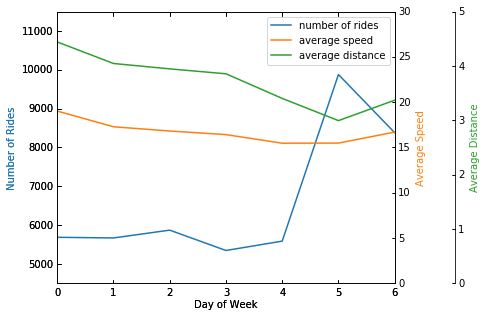

In [189]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

offset = 60
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right",
                                    axes=par2,
                                    offset=(offset, 0))

par2.axis["right"].toggle(all=True)


host.set_xlim(0, 6)
host.set_ylim(4500, 11500)

host.set_xlabel("Day of Week")
host.set_ylabel("Number of Rides")
par1.set_ylabel("Average Speed")
par2.set_ylabel("Average Distance")


p1, = host.plot([0,1,2,3,4,5,6], week_ride, label="number of rides")
p2, = par1.plot([0,1,2,3,4,5,6], week_avg, label="average speed")
p3, = par2.plot([0,1,2,3,4,5,6], week_dist, label="average distance")


par1.set_ylim(0, 30)
par2.set_ylim(0, 5)


host.legend()

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right"].label.set_color(p3.get_color())



plt.draw()
plt.show()